In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
from dask.local import get_async
from dask import bag as db
from dask import array as da
import sprite2
import numpy as np

logging.debug("test")

### call some functions remotely

In [3]:
hello_print = lambda o: f'this executes {o}'

In [4]:
hello_print('locally')

'this executes locally'

In [5]:
sprite2.invoke_remote_lambda(partial(hello_print, 'remotely'))

'this executes remotely'

In [6]:
a = np.arange(10)
def squareit():
    return a**a

In [7]:
squareit()

array([        1,         1,         4,        27,       256,      3125,
           46656,    823543,  16777216, 387420489])

In [8]:
%time sprite2.invoke_remote_lambda(squareit)

CPU times: user 3.77 ms, sys: 716 µs, total: 4.49 ms
Wall time: 33.4 ms


array([        1,         1,         4,        27,       256,      3125,
           46656,    823543,  16777216, 387420489])

In [9]:
%timeit sprite2.invoke_remote_lambda(squareit)

38.5 ms ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## do some dask stuff

In [10]:
b = db.range(100, npartitions=10)
bsum = b.sum()

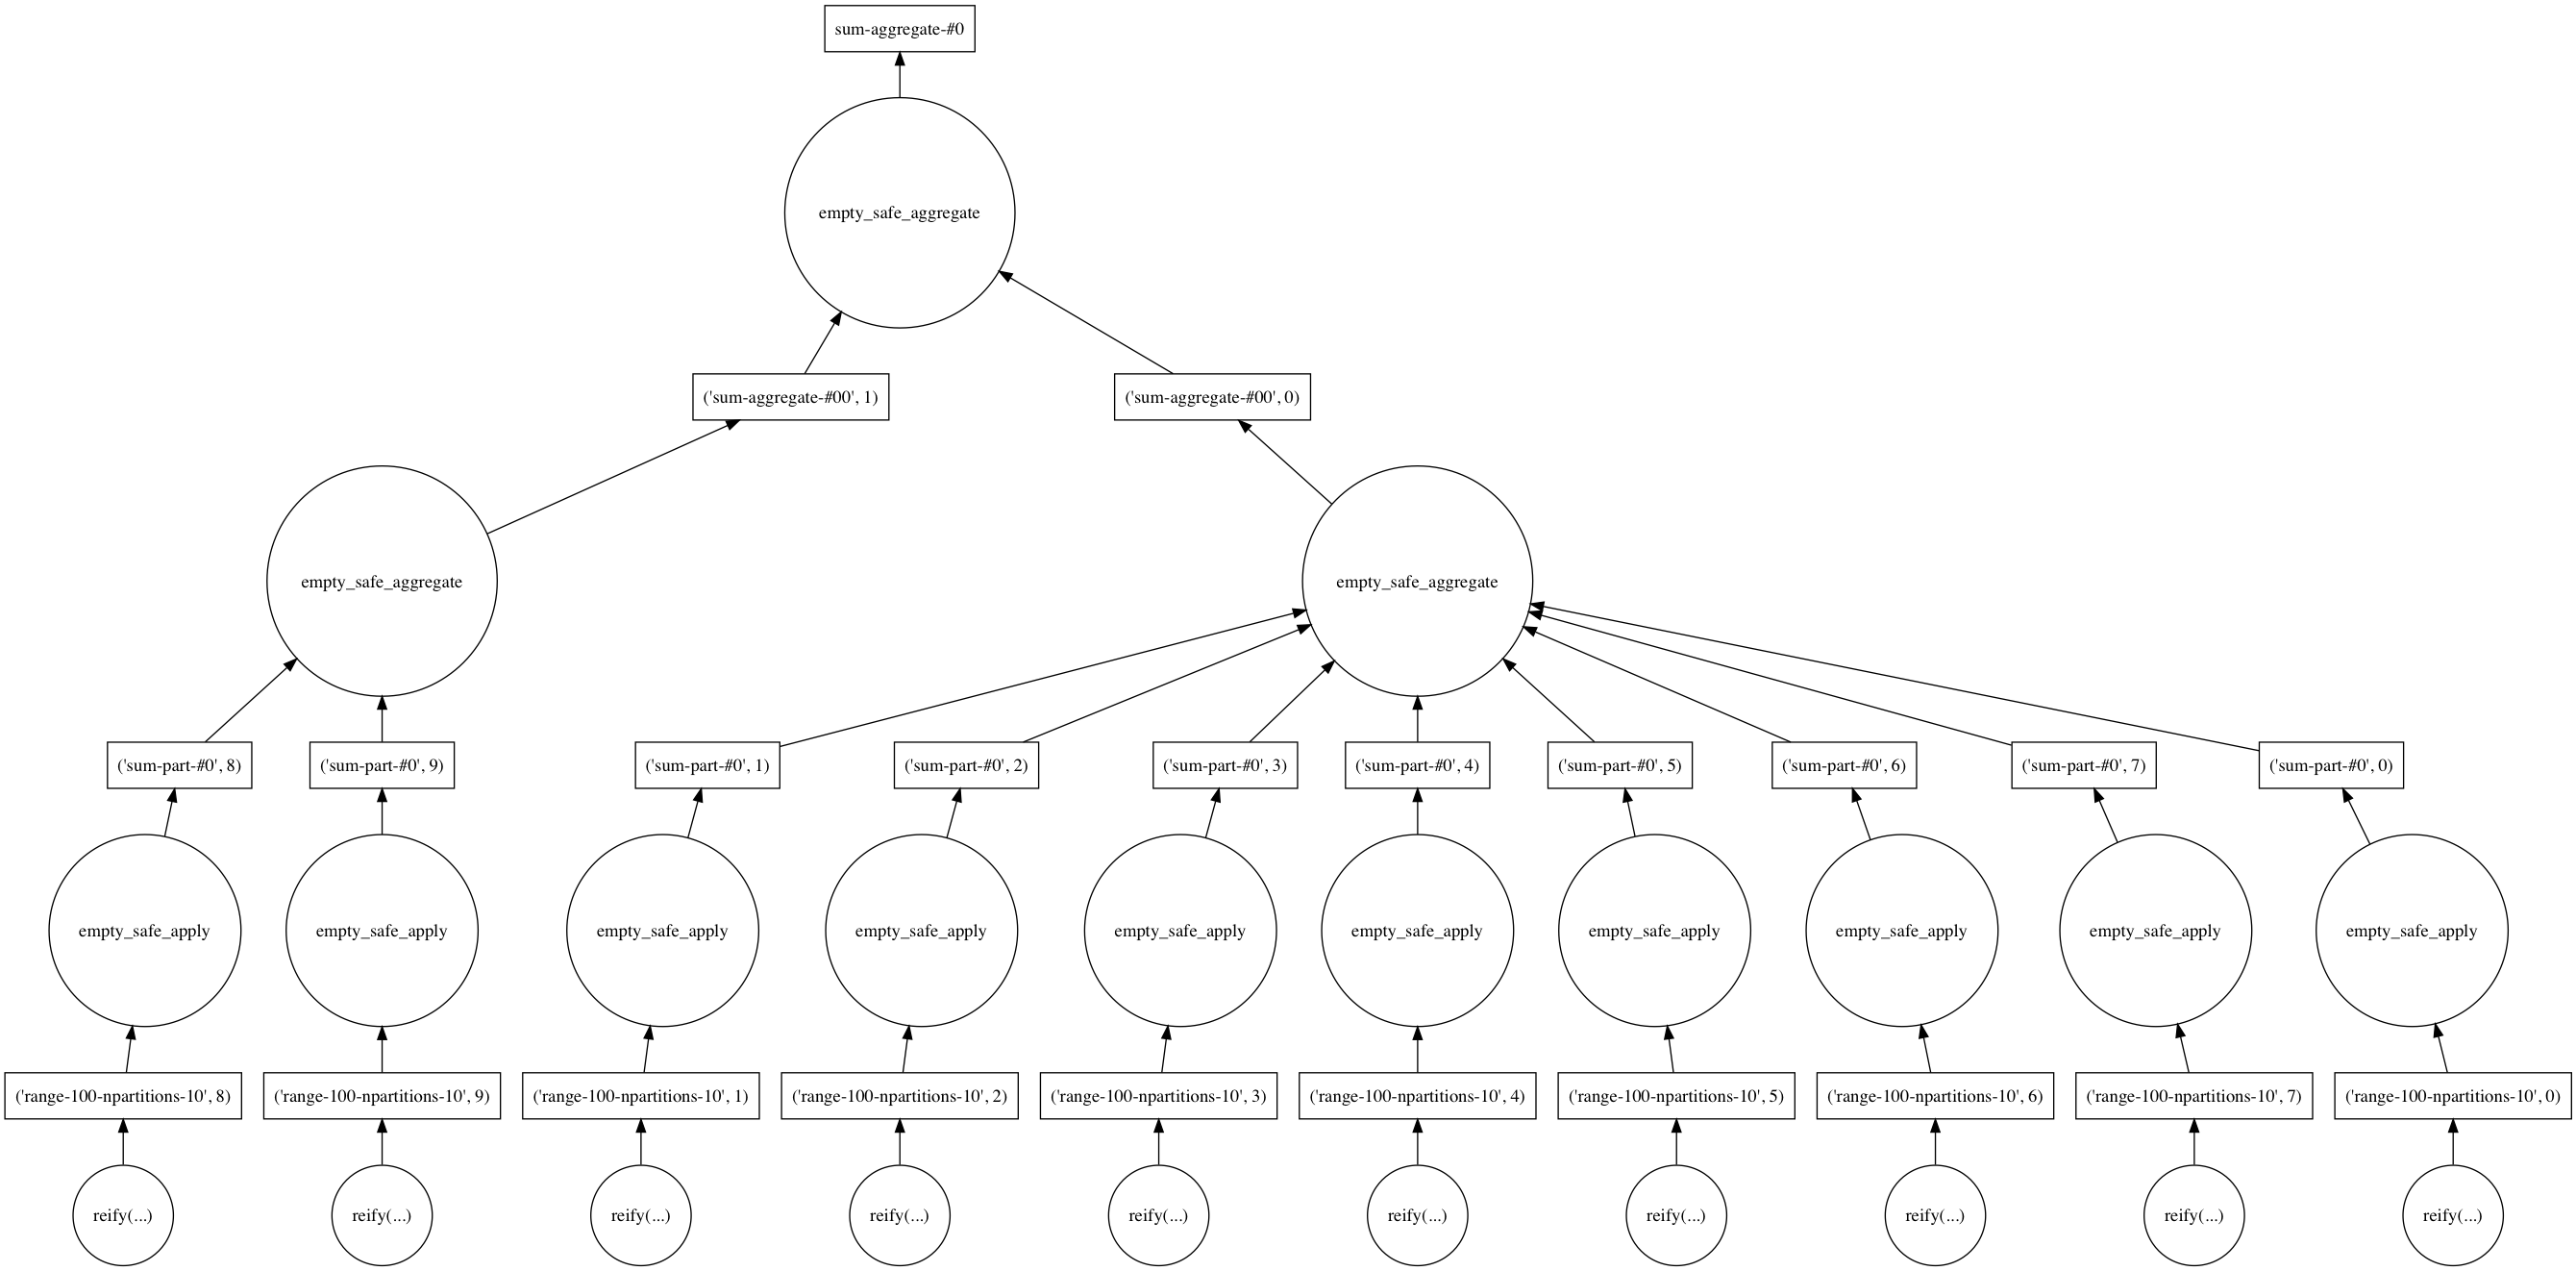

In [11]:
bsum.visualize()

In [12]:
%timeit bsum.compute(get=sprite2.get)

The slowest run took 6.37 times longer than the fastest. This could mean that an intermediate result is being cached.
336 ms ± 342 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
arrsum = da.arange(100, chunks=10).reshape((10,10)).sum(axis=1)

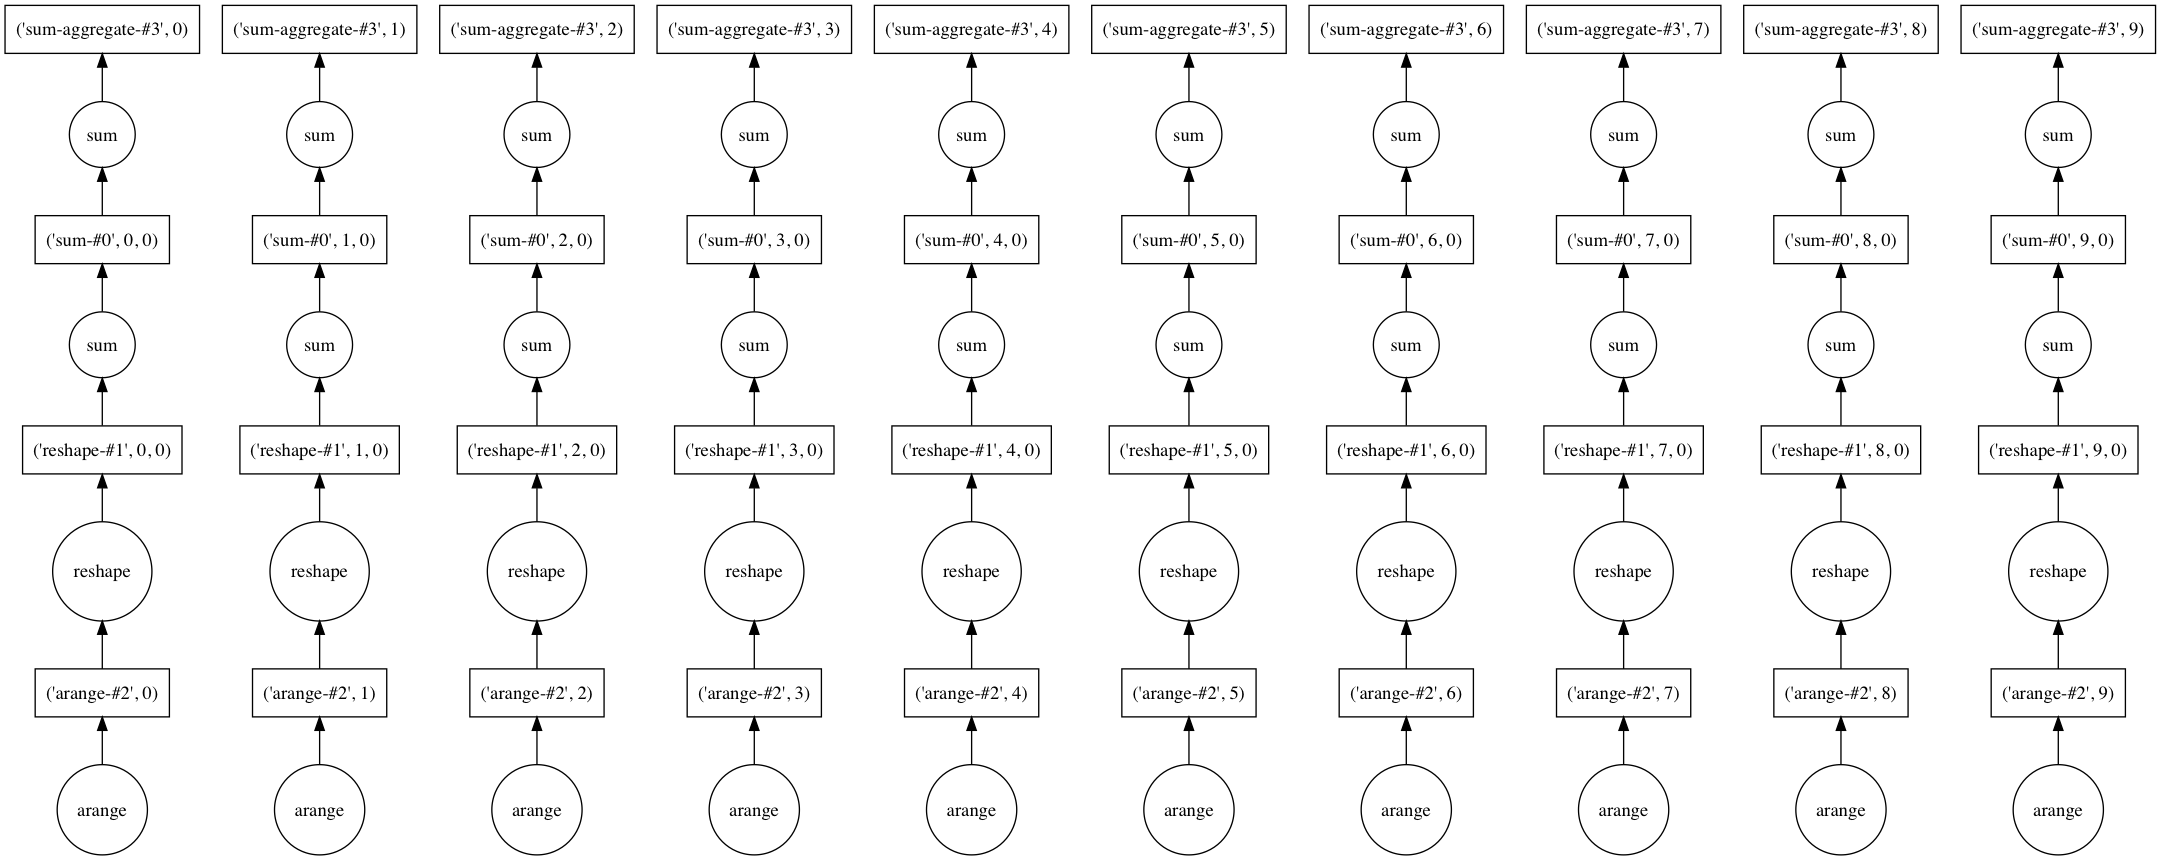

In [14]:
arrsum.visualize()

In [17]:
logger = logging.getLogger('sprite2')
logger.setLevel(logging.INFO)
%time arrsum.compute(get=sprite2.get)

CPU times: user 72.3 ms, sys: 8.09 ms, total: 80.4 ms
Wall time: 210 ms


array([ 45, 145, 245, 345, 445, 545, 645, 745, 845, 945])